In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score,precision_score,recall_score, mean_absolute_error, explained_variance_score, r2_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

In [6]:
train = pd.read_csv("train.csv")

mean_price = train['SalePrice'].mean()
std_price = train['SalePrice'].std()

low_price = mean_price - std_price
mid_price = mean_price + std_price

def categorizar_casas(precio):
    if precio <= low_price:
        return "Barata"
    elif precio <= mid_price:
        return "Normal"
    else:
        return "Cara"

train['Categoria'] = train['SalePrice'].apply(categorizar_casas)

train['Categoria'].value_counts()


Categoria
Normal    1145
Cara       191
Barata     124
Name: count, dtype: int64

In [8]:

X = train.drop(columns=["SalePrice", "Categoria"])
y = train["Categoria"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 80)
(292, 80)
(1168,)
(292,)


In [13]:
categorical_columns_selector = selector(dtype_include=object)
numerical_columns_selector = selector(dtype_exclude=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

numerical_imputer = SimpleImputer(strategy='constant', fill_value=0)
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unavailable')

categorical_preprocessor = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

numerical_preprocessor = Pipeline(steps=[
    ('imputer', numerical_imputer),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)
])

In [14]:
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',GaussianNB())
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unavailable',
                                                                                 strategy='constant')),
                                                                  ('one-hot-encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighbo...
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'GarageArea', 'WoodDeckSF',
                                                   'OpenPorchSF', ...])])),
                ('regressor', GaussianNB())])

In [20]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.3253
Precision: 0.6440
Recall: 0.3253
F1-score: 0.3137


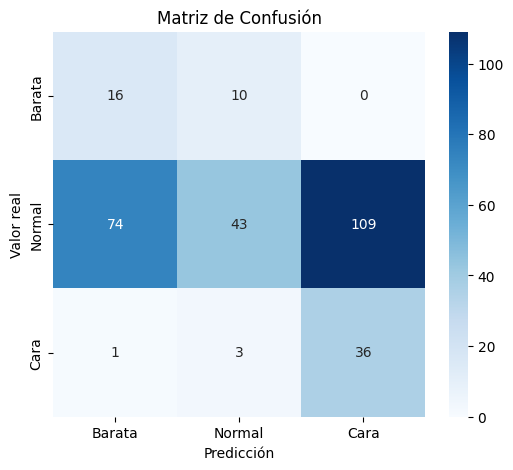

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=["Barata", "Normal", "Cara"])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Barata", "Normal", "Cara"], yticklabels=["Barata", "Normal", "Cara"])
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.show()

En este caso podemos ver un desempeño muy pobre del modelo de clasificación. Viendo las métricas, vemos que accuracy, recall y f1-score tienen valores similares entre 0.3137 y 0.3253. Es importante destacar que el average se colocó como weighted porque estamos trabajando con datos que no siguen una distribución normal. Por esa misma razón, el accuracy no es una métrica muy confiable. Sin embargo recall, que mide la cantidad de veces que se clasificó una casa en donde debería, también es un valor muy bajo. Esto muestra que el modelo falla en detectar muchas de las clasificaciones y solo logra captar bien una categoría. Por otra parte, la precisión es bastante altavde 0.6440. Esto va de la mano con lo que se decía antes de que cuando sí se califica bien una casa, lo hace bastante bien. Si embargo, como ya se mencionó, el f1-score, que es una mezcla entre la predicción y el recall, sigue mostrando un valor bajo, lo que nos lleva a la conclusión de que el modelo no tiene un buen desempeño. La matriz de confusión solo hace más claro el problema mostrando que en las predicciones casi siempre se ponian las casas como "normal", cuando realmente eran de otra categoría. Aún así se logra apreciar que en la variable "Normal" es donde menos cometío errores, lo que concuerda con el análisis anterior.